In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

# SELLER P&L ANALYSIS

The goal of this exercise is to compute, for each `seller_id`:

- The **revenue** it brings (10% of each sales + 80 BRL per month)
- The **cost** associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- The resulting **profit** made by Olist for each seller

❓ Let's not start all again from scratch! Import your seller training set and investigate what you already have.


In [2]:
from olist.seller import Seller

sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,5.00,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.000000,0.000000,1.00,1,1,1.000,167.99


### Revenue from commissions

In [3]:
commission_revenue = sellers.sales / 10

### Revenue from membership fees
BRL 80 per seller per month

#### Months on Olist

In [4]:
np.ceil((sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, "M"))

0        4.0
1       15.0
2        0.0
3        0.0
4        0.0
        ... 
2962     1.0
2963    14.0
2964     5.0
2965     5.0
2966     0.0
Length: 2967, dtype: float64

**Problem**: Sellers with a single sale were on Olist for zero months

In [5]:
months_on_olist = (
    np.floor(
        (sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, "M")
    )
    + 1
)
months_on_olist.head()

0     4.0
1    15.0
2     1.0
3     1.0
4     1.0
dtype: float64

In [6]:
months_on_olist = np.ceil(
    (sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, "M")
).map(lambda x: max(1, x))
months_on_olist.head()

0     4.0
1    15.0
2     1.0
3     1.0
4     1.0
dtype: float64

In [7]:
sellers["revenue"] = commission_revenue + months_on_olist * 80
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales,revenue
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07,2370.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,5.00,1,1,1.000,79.99,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.000000,0.000000,1.00,1,1,1.000,167.99,96.799


❓ What is missing? Write down a strategy to get your missing columns, by re-using as much of  what has already been coded in `seller.py` as possible

We need to get each review score individually, not the average score. Let's go back to our `seller.py` and tweak our code.

In [8]:
from olist.seller_updated import Seller

df = Seller().get_review_score() # we commented out the groupby from the python file
df.head()

,order_id,seller_id,dim_is_five_star,dim_is_one_star,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,0,0,4
1,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,0,0,4
2,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,1,0,5
3,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,1,0,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,1,0,5


What we need to do:
1. Add a new column: `cost_of_review` (_by mapping over the `review_score` to attribute the cost of each score to each order_)
2. Group by `seller_id`
3. Sum over the rows

In [9]:
def cost_of_review(review_score: int):
    # review_score is one element of the series
    if review_score == 1:
        return 100
    if review_score == 2:
        return 50
    if review_score == 3:
        return 40
    return 0


df.review_score.map(cost_of_review);

In [10]:
df["cost_of_review"] = df.review_score.map({1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
df.tail()

,order_id,seller_id,dim_is_five_star,dim_is_one_star,review_score,cost_of_review
100563,9c5dedf39a927c1b2549525ed64a053c,e24fc9fcd865784fb25705606fe3dfe7,1,0,5,0
100564,63943bddc261676b46f01ca7ac2f7bd8,1f9ab4708f3056ede07124aad39a2554,0,0,4,0
100565,83c1379a015df1e13d02aae0204711ab,d50d79cb34e38265a8649c383dcffd48,1,0,5,0
100566,11c177c8e97725db2631073c19f07b62,a1043bafd471dff536d0c462352beb48,0,0,2,50
100567,66dea50a8b16d9b4dee7af250b4be1a5,ececbfcff9804a2d6b40f589df8eef2b,1,0,5,0


In [11]:
df.groupby("seller_id").cost_of_review.sum()

seller_id
0015a82c2db000af6aaaf3ae2ecb0532     100
001cca7ae9ae17fb1caed9dfb1094831    3560
001e6ad469a905060d959994f1b41e4f     100
002100f778ceb8431b7a1020ff7ab48f    1110
003554e2dce176b5555353e4f3555ac8       0
                                    ... 
ffcfefa19b08742c5d315f2791395ee5     100
ffdd9f82b9a447f6f8d4b91554cc7dd3     190
ffeee66ac5d5a62fe688b9d26f83f534     200
fffd5413c0700ac820c7069d66d98c89    1360
ffff564a4f9085cd26170f4732393726    1420
Name: cost_of_review, Length: 3090, dtype: int64

❓ Update `seller.py` accordingly

_See `seller_updated.py`_

❓ Compute seller profits

In [12]:
sellers = Seller().get_training_data()

sellers["profits_before_it_costs"] = sellers.revenue - sellers.cost_of_reviews
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenue,profits_before_it_costs
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799,-3.201


❓ Sort sellers by profit, and analyse their profitability: conclude on a possible strategy for Olist!

In [13]:
sellers.sort_values("profits_before_it_costs")

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenue,profits_before_it_costs
769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,0.124729,0.514100,3.937093,35290,1854,2039,1.099784,123304.83,13850.483,-21439.517
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,0.143809,0.482510,3.827873,39400,1806,2009,1.112403,200472.92,21647.292,-17752.708
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,0.116092,0.584483,4.077586,29530,1706,1819,1.066237,104288.42,11948.842,-17581.158
945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,0.113935,0.527607,3.997371,20220,1146,1204,1.050611,37177.52,4757.752,-15462.248
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,0.118211,0.568690,4.074547,15440,943,1018,1.079533,17535.69,2553.569,-12886.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,0.112621,0.629126,4.194175,7500,521,542,1.040307,128111.19,14651.119,7151.119
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,0.066265,0.692771,4.421687,1520,166,175,1.054217,79284.55,8808.455,7288.455
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,0.086059,0.676420,4.339071,6510,585,586,1.001709,194042.03,21004.203,14494.203
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,0.101493,0.629851,4.214925,4700,336,340,1.011905,176431.87,19403.187,14703.187


<AxesSubplot:>

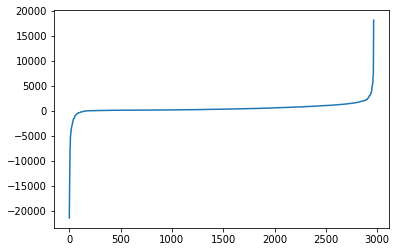

In [14]:
sellers.sort_values(
    "profits_before_it_costs", ignore_index=True
).profits_before_it_costs.plot()

<AxesSubplot:>

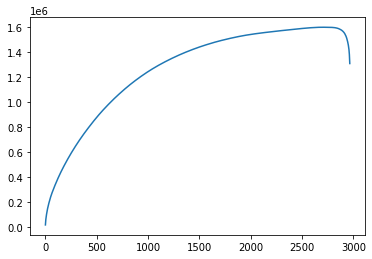

In [15]:
sellers.sort_values(
    "profits_before_it_costs", ignore_index=True, ascending=False
).profits_before_it_costs.cumsum().plot()